# Taylor-Hood elements for Stokes

This miniapp demonstrates a FEM implementation of the incompressible Stokes equations:


\begin{aligned}
\frac{\partial \mathbf{u}}{\partial t} - \nu \nabla^2 \mathbf{u} + \nabla p &= 0 \quad \text{in } \Omega, \\
\nabla \cdot \mathbf{u} &= 0 \quad \text{in } \Omega,
\end{aligned}


---

- Uses **Taylor–Hood elements** for mixed finite element formulation.
- **P2–P1** elements:
  - Velocity: Continuous piecewise **quadratic** functions ($\mathbb{P}_2$)
  - Pressure: Continuous piecewise **linear** functions ($\mathbb{P}_1$)

---

### Import Libraries (Only Numpy, Matlotlib and SciPy are allowed)

In [136]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri

from scipy.spatial import Delaunay
from scipy.sparse import bmat, csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import griddata

### Functions pertaining to Mesh and P1/P2 elements

In [137]:
def generate_triangular_mesh(x_len=1.0, y_len=1.0, mesh_size=0.1):
    num_x = int(x_len / mesh_size) + 1
    num_y = int(y_len / mesh_size) + 1
    x = np.linspace(0, x_len, num_x)
    y = np.linspace(0, y_len, num_y)
    X, Y = np.meshgrid(x, y)
    points = np.vstack([X.ravel(), Y.ravel()]).T
    triangulation = Delaunay(points)
    mesh = {
        'points': points,
        'triangles': triangulation.simplices,  # Element node indices
        'num_x': num_x,
        'num_y': num_y
    }
    return mesh


def generate_quadratic(V, E):
    """
    Generate a quadratic element list by adding midpoints to each edge.
    Parameters:
      V : ndarray of shape (nv, 2) with vertex coordinates.
      E : ndarray of shape (ne, 3) with triangle connectivity.
      return_edges : bool, optional. If True, also return the list of edges.

    Returns:
      V2 : ndarray with original vertices and new mid–edge nodes.
      E2 : ndarray of shape (ne, 6) with connectivity: first three columns for vertices,
           next three columns for corresponding mid–edge nodes.
      (if return_edges==True, also returns Edges, an array of edge vertex indices)
    """

    ne = E.shape[0]

    # Build a vertex-to-vertex graph (each triangle gives 3 edges)
    ID = np.kron(np.arange(0, ne), np.ones((3,), dtype=int))
    from scipy.sparse import coo_matrix, tril
    G = coo_matrix((np.ones((ne * 3,), dtype=int), (E.ravel(), ID)))
    V2V = G * G.T

    # Compute midpoints for these edges (New P2 nodes)
    V2Vmid = tril(V2V, -1)
    Edges = np.vstack((V2Vmid.row, V2Vmid.col)).T
    Vmid = (V[Edges[:, 0], :] + V[Edges[:, 1], :]) / 2.0
    V2 = np.vstack((V, Vmid))

    # Map each edge to the new node number (at the end of V)
    maxindex = E.max() + 1
    newID = maxindex + np.arange(Edges.shape[0])
    V2Vmid.data = newID
    V2Vmid = V2Vmid + V2Vmid.T

    # Add the new edges to each element
    E2 = np.hstack((E, np.zeros((ne, 3), dtype=int)))
    E2[:, 3] = np.array(V2Vmid[E[:, 0], E[:, 1]]).flatten()
    E2[:, 4] = np.array(V2Vmid[E[:, 1], E[:, 2]]).flatten()
    E2[:, 5] = np.array(V2Vmid[E[:, 2], E[:, 0]]).flatten()

    return V2, E2


def plot_mesh(mesh, element_order="P1", x_len=1.0, y_len=1.0):
    if element_order == "P1":
        points, triangles = mesh['points'], mesh['triangles']
        title = "Pressure Mesh (P1 Elements)"
    elif element_order == "P2":
        points, triangles = mesh['V2'], mesh['E2'][:, :3]
        title = "Velocity Mesh (P2 Elements)"
    else:
        raise ValueError("element_order must be either 'P1' or 'P2'")

    tri_obj = tri.Triangulation(points[:, 0], points[:, 1], triangles)
    plt.figure(figsize=(6, 6))
    plt.triplot(tri_obj, color='blue')
    plt.plot(points[:, 0], points[:, 1], 'o', color='red', markersize=2)
    plt.xlim(0, x_len)
    plt.ylim(0, y_len)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.show()

    num_nodes = points.shape[0]
    num_triangles = triangles.shape[0]
    print("Mesh Summary ({}):".format(element_order))
    print(" - Number of nodes:", num_nodes)
    print(" - Number of triangles:", num_triangles)
    print(" - Domain: {:.2f} x {:.2f}".format(x_len, y_len))


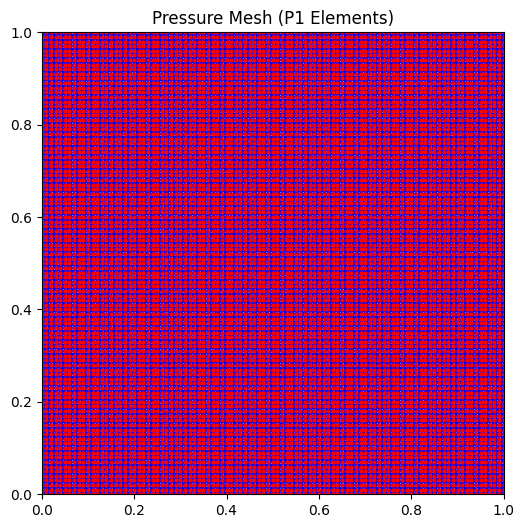

Mesh Summary (P1):
 - Number of nodes: 10201
 - Number of triangles: 20000
 - Domain: 1.00 x 1.00


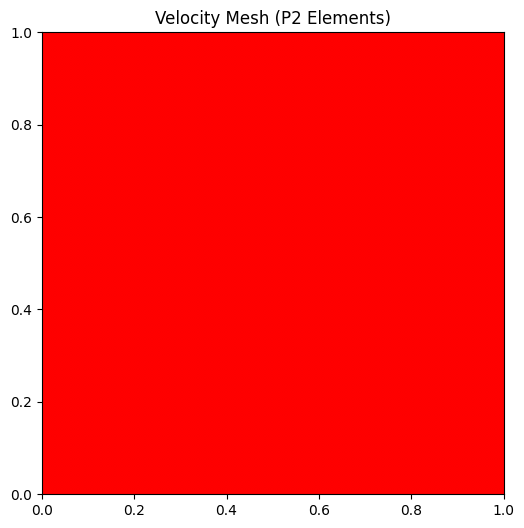

Mesh Summary (P2):
 - Number of nodes: 40401
 - Number of triangles: 20000
 - Domain: 1.00 x 1.00


In [138]:
mesh = generate_triangular_mesh(x_len=1.0, y_len=1.0, mesh_size=0.01)
mesh['V2'], mesh['E2'] = generate_quadratic(mesh['points'], mesh['triangles'])

plot_mesh(mesh, element_order="P1")
plot_mesh(mesh, element_order="P2")

In [139]:

def assemble_stokes_system(mesh, kinematic_viscosity=1.0):
    """
    Assemble the finite element matrices for the steady Stokes equations
    using Taylor–Hood elements.

    Inputs:
       mesh : dict with keys 'points' and 'triangles' (P1 mesh for pressure)
       nu   : viscosity

    Returns:
       S : Global saddle–point system matrix in CSR format.
       rhs : Right–hand side vector.
       dof_info : dictionary of degrees of freedom indices for velocity and pressure.
                  'vel' indices range for velocity (each with 2 components) and
                  'pres' for pressure (P1 nodes).
    """
    # Number of degrees of freedom
    N_pres = mesh['points'].shape[0]  # pressure dofs (original mesh vertices)
    N_vel = mesh['V2'].shape[0]  # velocity dofs (each node has two components)
    ndof_vel = 2 * N_vel
    ndof = ndof_vel + N_pres

    # Prepare lists for COO entries for the blocks A and B.
    rows_A = []
    cols_A = []
    vals_A = []

    rows_B = []  # for the coupling matrix B (pressure vs. velocity)
    cols_B = []
    vals_B = []

    # For the force vector, assume f = 0 for simplicity.
    f_global = np.zeros(ndof_vel)
    # Pressure right-hand side is also zero.
    g_global = np.zeros(N_pres)

    # Quadrature rule for triangles (6–point rule)
    quad_pts = np.array([
        [-0.10810301816807008, -0.78379396366385990],
        [-0.10810301816806966, -0.10810301816807061],
        [-0.78379396366386020, -0.10810301816806944],
        [-0.81684757298045740, -0.81684757298045920],
        [0.63369514596091700, -0.81684757298045810],
        [-0.81684757298045870, 0.63369514596091750]
    ])
    quad_w = np.array([
        0.44676317935602256,
        0.44676317935602256,
        0.44676317935602256,
        0.21990348731064327,
        0.21990348731064327,
        0.21990348731064327
    ])
    # Map quadrature points from [-1,1] to [0,1] (affine map for the reference triangle)
    xi_q = (quad_pts[:, 0] + 1) / 2
    eta_q = (quad_pts[:, 1] + 1) / 2
    w_q = quad_w * 0.5  # adjust weights

    ne = mesh['E2'].shape[0]
    for ei in range(ne):
        # Velocity element connectivity: 6 nodes (indices into V2)
        vel_nodes = mesh['E2'][ei, :]  # shape (6,)
        # Pressure element connectivity: first 3 vertices (indices into mesh['points'])
        pres_nodes = mesh['E2'][ei, :3]

        # Geometry: use the three pressure nodes for affine mapping.
        vertices = mesh['points'][pres_nodes, :]  # shape (3, 2)
        x0, y0 = vertices[0, :]
        x1, y1 = vertices[1, :]
        x2, y2 = vertices[2, :]
        J = np.array([[x1 - x0, x2 - x0],
                      [y1 - y0, y2 - y0]])
        detJ = np.linalg.det(J)
        if detJ <= 0:
            raise ValueError("Non–positive Jacobian determinant encountered.")
        invJ = np.linalg.inv(J)

        # Local matrices initialization.
        A_loc = np.zeros((12, 12))  # 6 nodes * 2 velocity components
        B_loc = np.zeros((3, 12))  # 3 pressure nodes x 12 velocity dofs

        # Loop over quadrature points.
        for (xi, eta, w) in zip(xi_q, eta_q, w_q):
            # Quadratic velocity basis functions (P2) on the reference triangle.
            N_basis = np.array([
                (1 - xi - eta) * (1 - 2 * xi - 2 * eta),  # N1
                xi * (2 * xi - 1),  # N2
                eta * (2 * eta - 1),  # N3
                4 * xi * (1 - xi - eta),  # N4
                4 * xi * eta,  # N5
                4 * eta * (1 - xi - eta)  # N6
            ])
            # Derivatives with respect to xi and eta.
            dN_dxi = np.array([
                -3 + 4 * xi + 4 * eta,
                4 * xi - 1,
                0,
                4 - 8 * xi - 4 * eta,
                4 * eta,
                -4 * eta
            ])
            dN_deta = np.array([
                -3 + 4 * xi + 4 * eta,
                0,
                4 * eta - 1,
                -4 * xi,
                4 * xi,
                4 - 4 * xi - 8 * eta
            ])
            # Transform derivatives to physical coordinates.
            grad_N = np.zeros((6, 2))
            for i in range(6):
                dN_ref = np.array([dN_dxi[i], dN_deta[i]])
                grad_N[i, :] = invJ.T @ dN_ref

            # Linear pressure basis functions (P1, barycentrics) and their constant gradients.
            phi = np.array([1 - xi - eta, xi, eta])
            dphi_ref = np.array([[-1, -1],
                                 [1, 0],
                                 [0, 1]])
            grad_phi = (invJ.T @ dphi_ref.T).T  # shape (3, 2)

            weight = w * detJ
            # Assemble local velocity matrix.
            for i in range(6):
                for j in range(6):
                    grad_dot = np.dot(grad_N[i], grad_N[j])
                    A_loc[i, j] += kinematic_viscosity * grad_dot * weight  # u-u block
                    A_loc[i + 6, j + 6] += kinematic_viscosity * grad_dot * weight  # v-v block
            # Assemble coupling (divergence) matrix.
            for a in range(3):
                for j in range(6):
                    B_loc[a, j] += - phi[a] * grad_N[j, 0] * weight  # u-component
                    B_loc[a, j + 6] += - phi[a] * grad_N[j, 1] * weight  # v-component

        # Global assembly for velocity.
        for local_i in range(12):
            # Skip near-zero diagonal entries for efficiency.
            if abs(A_loc[local_i, local_i]) < 1e-14:
                continue
            if local_i < 6:
                gi = vel_nodes[local_i]  # u-component index
            else:
                gi = vel_nodes[local_i - 6] + N_vel  # v-component index (N_vel is the total number of velocity nodes)
            for local_j in range(12):
                if local_j < 6:
                    gj = vel_nodes[local_j]
                else:
                    gj = vel_nodes[local_j - 6] + N_vel
                rows_A.append(gi)
                cols_A.append(gj)
                vals_A.append(A_loc[local_i, local_j])

        # Global assembly for coupling matrix B.
        for a in range(3):
            gi_p = pres_nodes[a]  # pressure dof (in original mesh)
            # Global pressure index is shifted after velocity dofs.
            for local_j in range(12):
                if local_j < 6:
                    gj = vel_nodes[local_j]
                else:
                    gj = vel_nodes[local_j - 6] + N_vel
                rows_B.append(gi_p)
                cols_B.append(gj)
                vals_B.append(B_loc[a, local_j])

    # Build the global velocity stiffness matrix.
    A_global = csr_matrix((vals_A, (rows_A, cols_A)), shape=(ndof_vel, ndof_vel))
    # Build the coupling matrix B (size: N_pres x ndof_vel).
    B = csr_matrix((vals_B, (np.array(rows_B), np.array(cols_B))), shape=(N_pres, ndof_vel))

    # Create the full saddle–point system matrix.
    zero_pp = csr_matrix((N_pres, N_pres))
    S = bmat([[A_global, -B.transpose()],
              [B, zero_pp]], format='csr')

    # Assemble the global right–hand side.
    rhs = np.concatenate([f_global, g_global])

    dof_info = {'vel': np.arange(ndof_vel), 'pres': np.arange(ndof_vel, ndof)}
    return S, rhs, dof_info


# Example usage:
print("Assembling system...")
S, rhs, dof_info = assemble_stokes_system(mesh, kinematic_viscosity=1000.0)
print("Global system size:", S.shape)


Assembling system...
Global system size: (91003, 91003)


In [140]:
# For the velocity we impose homogeneous Dirichlet conditions (u=0) on the boundary,
# and for pressure we fix one degree of freedom (p=0) for uniqueness.

def apply_boundary_conditions(S, rhs, mesh, dof_info, vel_tol=1e-6):
    ndof = S.shape[0]
    S = S.tolil()

    N_vel = mesh['V2'].shape[0]
    # Identify velocity nodes on the boundary (unit square).
    boundary_vel_nodes = []
    for i, (x, y) in enumerate(mesh['V2']):
        if (abs(x - 0) < vel_tol or abs(x - 1) < vel_tol or
                abs(y - 0) < vel_tol or abs(y - 1) < vel_tol):
            boundary_vel_nodes.append(i)
    boundary_dofs = []
    for node in boundary_vel_nodes:
        boundary_dofs.append(node)  # u-component
        boundary_dofs.append(node + N_vel)  # v-component

    # Enforce u = 1 on the top lid
    for dof in boundary_dofs:
        # Check if the node is on the top boundary (y = 1)
        node_index = dof % N_vel  # Get the node index
        if abs(mesh['V2'][node_index, 1] - 1) < vel_tol:
            if dof < N_vel:  # u-component
                S[dof, :] = 0
                S[dof, dof] = 1.0
                rhs[dof] = 1.0  # Set u = 1
            else:
                S[dof, :] = 0
                S[dof, dof] = 1.0
                rhs[dof] = 0.0  # Set v = 0 (as before)
        else:
            # Other boundaries (u = 0, v = 0)
            S[dof, :] = 0
            S[dof, dof] = 1.0
            rhs[dof] = 0.0

    # Remove the Null space, so fix a pressure point to 0
    p_fix = dof_info['pres'][0]
    S[p_fix, :] = 0
    S[p_fix, p_fix] = 1.0
    rhs[p_fix] = 0.0

    return S.tocsr(), rhs


S_bc, rhs_bc = apply_boundary_conditions(S, rhs, mesh, dof_info)
print("Applied boundary conditions.")


Applied boundary conditions.


In [141]:
print("Solving the linear system...")
sol = spsolve(S_bc, rhs_bc)
print("Solution computed.")

# Extract components from blocked vector
N_vel = mesh['V2'].shape[0]
u = sol[:N_vel]
v = sol[N_vel:2 * N_vel]
p = sol[2 * N_vel:]

Solving the linear system...
Solution computed.


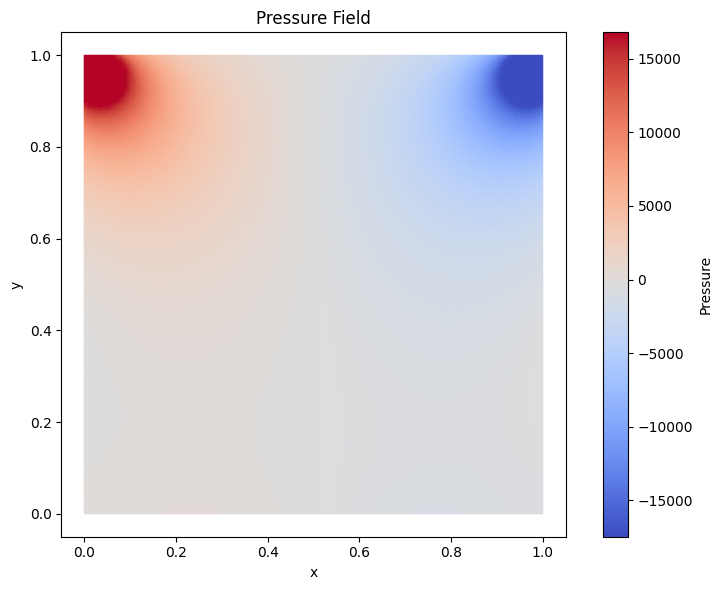

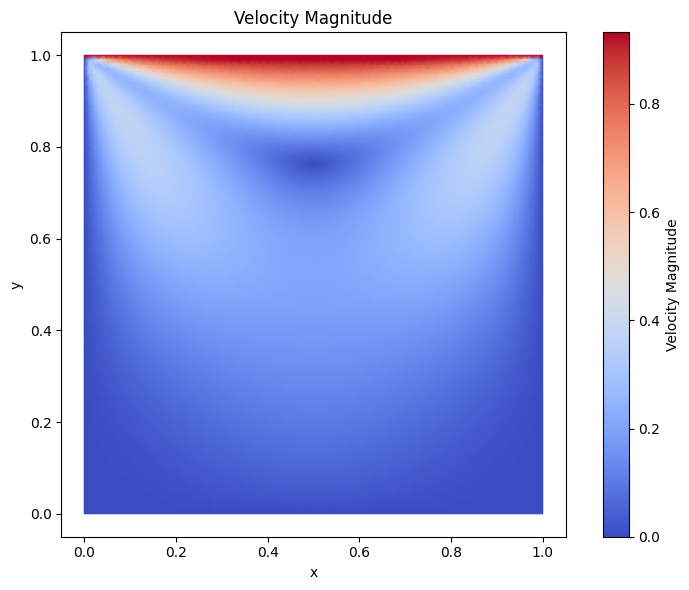

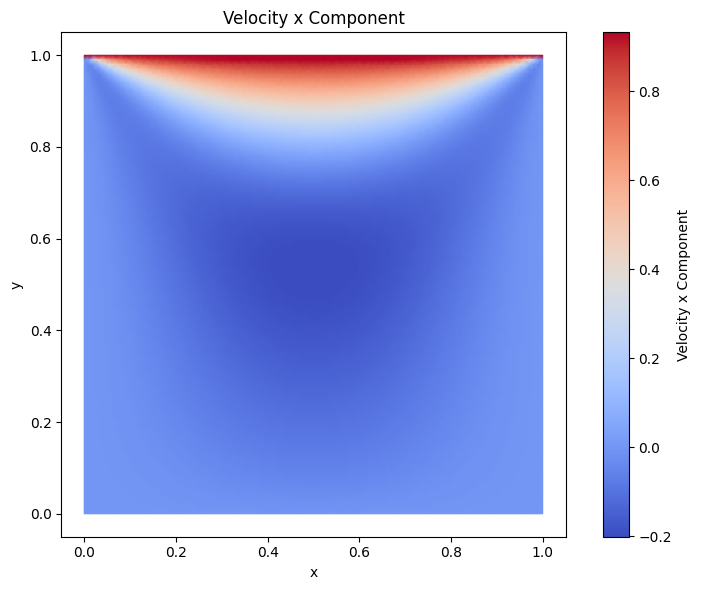

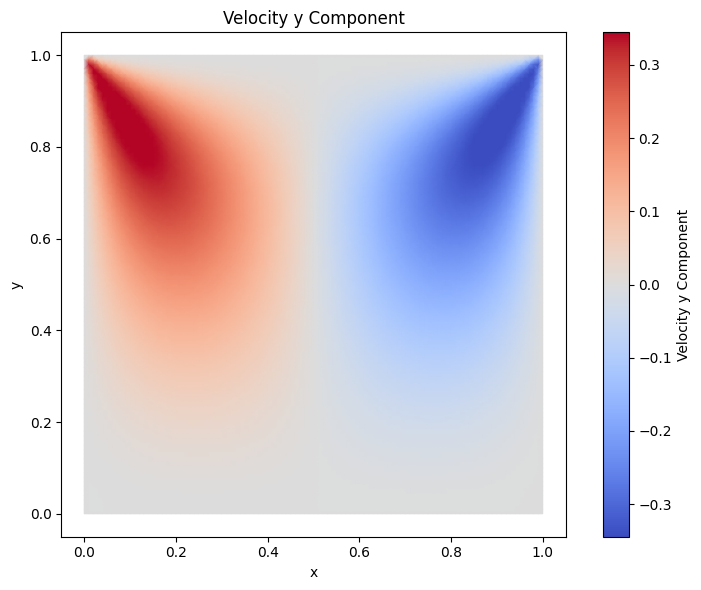

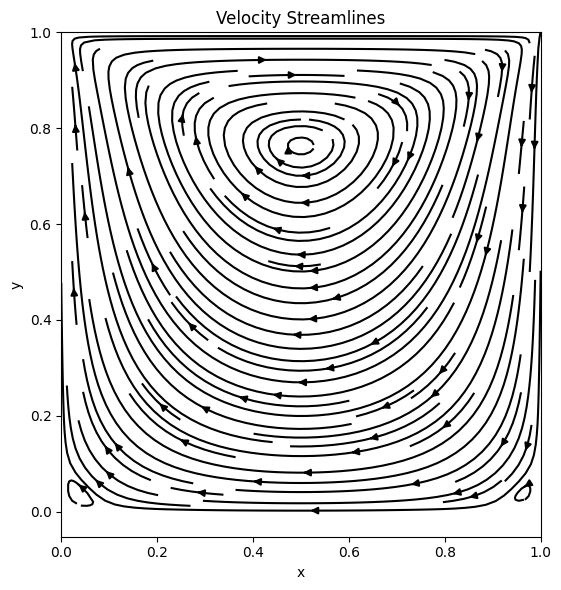

In [142]:

def plot_field(points, triangles, field, field_label, title, cmap='coolwarm', percentile_clip=(1, 99)):
    fmin, fmax = np.percentile(field, percentile_clip)

    plt.figure(figsize=(8, 6))
    tri_obj = tri.Triangulation(points[:, 0], points[:, 1], triangles)

    tpc = plt.tripcolor(tri_obj, field, shading='gouraud', cmap=cmap, vmin=fmin, vmax=fmax)

    plt.colorbar(tpc, label=field_label)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()


def plot_streamlines(points, u, v):
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])

    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])
    num_x = len(unique_x) if len(unique_x) > 1 else 50
    num_y = len(unique_y) if len(unique_y) > 1 else 50

    xi = np.linspace(x_min, x_max, num_x)
    yi = np.linspace(y_min, y_max, num_y)
    Xg, Yg = np.meshgrid(xi, yi)

    Ug = griddata(points, u, (Xg, Yg), method='linear')
    Vg = griddata(points, v, (Xg, Yg), method='linear')

    plt.figure(figsize=(8, 6))
    plt.streamplot(xi, yi, Ug, Vg, density=1.5, color='k')
    plt.title("Velocity Streamlines")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Plot pressure field
plot_field(mesh['points'], mesh['triangles'], p,
           field_label='Pressure',
           title='Pressure Field')

# Plot velocity magnitude
plot_field(mesh['V2'], mesh['E2'][:, :3], np.sqrt(u**2 + v**2),
           field_label='Velocity Magnitude',
           title='Velocity Magnitude')

# Plot x-velocity
plot_field(mesh['V2'], mesh['E2'][:, :3], u,
           field_label='Velocity x Component',
           title='Velocity x Component')

# Plot y-velocity
plot_field(mesh['V2'], mesh['E2'][:, :3], v,
           field_label='Velocity y Component',
           title='Velocity y Component')

# Plot velocity streamlines
plot_streamlines(mesh['V2'], u, v)
